In [5]:
import numpy as np
from fractions import Fraction
directory = 'russle/'


dyn_rossler = {"a": 0.15, "b": 0.2, "c": 10 }
x0_rossler= np.array([0.0,0.0,0.0])

def Rossler (x0, dyn):
    a = dyn['a']
    b = dyn['b']
    c = dyn['c']
    x = x0[0]
    y = x0[1]
    z = x0[2]
    return np.array([-(y+z), x+ a*y, b + z*(x-c)])


def RungeKutta (dyn, f, dt, x0):
    k1 = f(x0, dyn)*dt #[x,y,z]*0.1 example
    k2 = f(x0+0.5*k1,dyn)*dt
    k3 = f(x0 + 0.5*k2, dyn)*dt
    k4 = f(x0 + k3, dyn)*dt
    
    x = x0 + (k1 + 2*k2 + 2*k3 + k4)/6
    return x

def f_t (dyn, f, dt, x0, T):
    x = np.empty(shape=(len(x0),T))
    print(x.shape)      
    for i in range(1,T):
        x[:, i] = RungeKutta(dyn, f, dt, x[:, i-1]) 
    return x




In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x_rossler = f_t(dyn_rossler, Rossler, 0.01, x0_rossler, 50000)


(3, 50000)


/tmp/ipykernel_9033/719743188.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


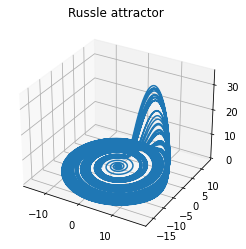

In [14]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(x_rossler[0], x_rossler[1], x_rossler[2])
plt.title('Russle attractor')
plt.draw()
plt.savefig(directory + 'Russle_attractor.png')

In [15]:
evolv_start = 1.5
taus = [1/12,3/4,1.5]
evolvs =  [evolv_start/2, evolv_start, evolv_start*2]

In [19]:
for tau in taus:
    for evolv in evolvs:

        IND = 0
        SUM = 0.0
        ITS = 0
        IND2 = 0

        DI = 1.e38 #any large number

        NPT = len(x_rossler[0])
        DIM = 3 #is dimension 12 ?
        dt = 0.01
        TAU_physical = tau #no TAU if full state
        TAU = int(TAU_physical/dt)
        SCALMX = 20
        SCALMN = 10
        EVOLV_physical = evolv #time from t0 to t1
        EVOLV = int(EVOLV_physical/dt)

        NPT = NPT - DIM*TAU - EVOLV

        Z = np.empty([NPT,DIM])

        #Z(I,J)=JTH COMPONENT OF ITH RECONSTRUCTED ATTRACTOR POINT
        for i in range(int(NPT)):
            for j in range(DIM):

                Z[i][j] = x_rossler[0][i + (j-1)*TAU]

        fig = plt.figure()
        ax = fig.gca(projection="3d")
        ax.plot(Z[:,0], Z[:,1], Z[:,2])
        plt.title('Russle attractor with tau = {a} & evolv = {b}'.format(a=round(TAU_physical, 3), b=EVOLV_physical) )
        plt.savefig(directory + 'russle_attractor'+ '_tau{a}evolv{b}'.format(a=round(TAU_physical, 3), b=EVOLV_physical) +'.png')
        plt.clf() 
        #find nearest neighbor to the first data point
        for i in range(1, int(NPT)):
            D = 0.0
            #iterate through the array, compare first point with the rest
            D = np.linalg.norm(Z[IND] - Z[i])
            if ((D<DI) and (D>=SCALMN)):
                DI = D
                IND2 = i
        SUM_list = []
        while ((IND + EVOLV < NPT) and (IND2 + EVOLV < NPT)): #40
            PT1 = Z[IND+EVOLV] #would this be the dimesion
            PT2 = Z[IND2+EVOLV]
            DF = np.linalg.norm(PT1 - PT2)
            ITS = ITS + 1
            SUM_list.append(SUM)
            SUM = SUM + np.log2(DF/DI)/EVOLV_physical
            ZLYAP = SUM/float(ITS)
            INDOLD = IND2
            ZMULT = 1.0
            ANGLMX = 0.3
            #THMIN = 3.14
            while (True): #70
                #print("here")
                THMIN = 3.14

                for i in range (int(NPT)): #100
                    III = int(np.absolute(i-(IND+EVOLV)))
                    if (III >= 10):
                        #find angular change old to new vector
                        DNEW = 0.0
                        DNEW = np.linalg.norm(PT1 - Z[i])
                        if ((DNEW <= ZMULT*SCALMX) and (DNEW >= SCALMN)):
                            DOT = 0.0
                            DOT = np.dot((PT1 - Z[i]),(PT1 - PT2))
                            CTH = np.absolute(DOT/(DNEW*DF))
                            #print(CTH)
                            if (CTH > 1.0):
                                CTH = 1.0
                            TH = np.arccos(CTH)
                            #save smallest angular change so far
                            if TH <= THMIN:
                                THMIN = TH
                                DII = DNEW
                                IND2 = i
                if (THMIN < ANGLMX):
                    #print ("here")
                    break
                # look at longer distance if cant find replacement
                ZMULT = ZMULT + 1
                if (ZMULT > 5):
                    #no replacement at 5*scale, double search angle, reset distance
                    ZMULT = 1.0
                    ANGLMX = 2.0*ANGLMX
                if (ANGLMX >= 3.14):
                    IND2 = INDOLD + EVOLV
                    DII = DF
            IND = IND + EVOLV
            if (IND > NPT):
                print('here')
                break
            print ("IND, IND2, NPT", IND, IND2, NPT)
            DI = DII
        plt.plot(SUM_list)
        #plt.scatter(range(len(SUM_list)),SUM_list)
        plt.title('Accumulated lyapunov exponents with tau = {a} & evolv = {b}'.format(a=round(TAU_physical, 3), b=EVOLV_physical))
        plt.ylabel('lyapunov exponents')
        plt.xlabel('iteration')
        plt.savefig(directory + 'russle_LE'+ '_tau{a}evolv{b}'.format(a=round(TAU_physical, 3), b=EVOLV_physical) +'.png')
        plt.clf()


/tmp/ipykernel_9033/1493012800.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 75 49573 49901
IND, IND2, NPT 150 15016 49901
IND, IND2, NPT 225 38168 49901
IND, IND2, NPT 300 22150 49901
IND, IND2, NPT 375 15560 49901
IND, IND2, NPT 450 38087 49901
IND, IND2, NPT 525 43628 49901
IND, IND2, NPT 600 13655 49901
IND, IND2, NPT 675 49573 49901
IND, IND2, NPT 750 15016 49901
IND, IND2, NPT 825 38168 49901
IND, IND2, NPT 900 22150 49901
IND, IND2, NPT 975 49573 49901
IND, IND2, NPT 1050 43552 49901
IND, IND2, NPT 1125 43627 49901
IND, IND2, NPT 1200 43702 49901
IND, IND2, NPT 1275 49573 49901
IND, IND2, NPT 1350 15016 49901
IND, IND2, NPT 1425 38168 49901
IND, IND2, NPT 1500 15482 49901
IND, IND2, NPT 1575 49573 49901
IND, IND2, NPT 1650 43552 49901
IND, IND2, NPT 1725 43627 49901
IND, IND2, NPT 1800 43702 49901
IND, IND2, NPT 1875 15560 49901
IND, IND2, NPT 1950 49026 49901
IND, IND2, NPT 2025 25409 49901
IND, IND2, NPT 2100 20935 49901
IND, IND2, NPT 2175 49573 49901
IND, IND2, NPT 2250 49027 49901
IND, IND2, NPT 2325 43633 49901
IND, IND2, NPT 2400 19

/tmp/ipykernel_9033/1493012800.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 150 13498 49826
IND, IND2, NPT 300 13648 49826
IND, IND2, NPT 450 13798 49826
IND, IND2, NPT 600 14528 49826
IND, IND2, NPT 750 14678 49826
IND, IND2, NPT 900 14828 49826
IND, IND2, NPT 1050 14978 49826
IND, IND2, NPT 1200 15128 49826
IND, IND2, NPT 1350 15278 49826
IND, IND2, NPT 1500 17249 49826
IND, IND2, NPT 1650 17399 49826
IND, IND2, NPT 1800 36372 49826
IND, IND2, NPT 1950 36522 49826
IND, IND2, NPT 2100 40320 49826
IND, IND2, NPT 2250 40470 49826
IND, IND2, NPT 2400 36371 49826
IND, IND2, NPT 2550 36521 49826
IND, IND2, NPT 2700 14799 49826
IND, IND2, NPT 2850 28320 49826
IND, IND2, NPT 3000 28470 49826
IND, IND2, NPT 3150 28620 49826
IND, IND2, NPT 3300 28770 49826
IND, IND2, NPT 3450 28920 49826
IND, IND2, NPT 3600 29070 49826
IND, IND2, NPT 3750 36819 49826
IND, IND2, NPT 3900 36969 49826
IND, IND2, NPT 4050 34708 49826
IND, IND2, NPT 4200 23316 49826
IND, IND2, NPT 4350 23466 49826
IND, IND2, NPT 4500 23616 49826
IND, IND2, NPT 4650 23766 49826
IND, IND2, NPT

/tmp/ipykernel_9033/1493012800.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 300 45838 49676
IND, IND2, NPT 600 26042 49676
IND, IND2, NPT 900 20915 49676
IND, IND2, NPT 1200 48548 49676
IND, IND2, NPT 1500 48848 49676
IND, IND2, NPT 1800 49148 49676
IND, IND2, NPT 2100 43350 49676
IND, IND2, NPT 2400 43650 49676
IND, IND2, NPT 2700 41507 49676
IND, IND2, NPT 3000 33304 49676
IND, IND2, NPT 3300 11416 49676
IND, IND2, NPT 3600 11716 49676
IND, IND2, NPT 3900 12016 49676
IND, IND2, NPT 4200 39300 49676
IND, IND2, NPT 4500 39600 49676
IND, IND2, NPT 4800 39900 49676
IND, IND2, NPT 5100 40200 49676
IND, IND2, NPT 5400 40500 49676
IND, IND2, NPT 5700 40800 49676
IND, IND2, NPT 6000 41100 49676
IND, IND2, NPT 6300 41400 49676
IND, IND2, NPT 6600 41700 49676
IND, IND2, NPT 6900 42000 49676
IND, IND2, NPT 7200 42300 49676
IND, IND2, NPT 7500 25874 49676
IND, IND2, NPT 7800 26174 49676
IND, IND2, NPT 8100 26474 49676
IND, IND2, NPT 8400 26774 49676
IND, IND2, NPT 8700 27074 49676
IND, IND2, NPT 9000 30344 49676
IND, IND2, NPT 9300 30644 49676
IND, IND2, 

/tmp/ipykernel_9033/1493012800.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 75 19548 49700
IND, IND2, NPT 150 19623 49700
IND, IND2, NPT 225 45220 49700
IND, IND2, NPT 300 45295 49700
IND, IND2, NPT 375 45370 49700
IND, IND2, NPT 450 45445 49700
IND, IND2, NPT 525 45520 49700
IND, IND2, NPT 600 45595 49700
IND, IND2, NPT 675 45670 49700
IND, IND2, NPT 750 39645 49700
IND, IND2, NPT 825 13630 49700
IND, IND2, NPT 900 13705 49700
IND, IND2, NPT 975 13780 49700
IND, IND2, NPT 1050 13855 49700
IND, IND2, NPT 1125 13930 49700
IND, IND2, NPT 1200 14005 49700
IND, IND2, NPT 1275 14080 49700
IND, IND2, NPT 1350 14155 49700
IND, IND2, NPT 1425 14230 49700
IND, IND2, NPT 1500 14305 49700
IND, IND2, NPT 1575 14380 49700
IND, IND2, NPT 1650 14455 49700
IND, IND2, NPT 1725 14530 49700
IND, IND2, NPT 1800 14605 49700
IND, IND2, NPT 1875 14680 49700
IND, IND2, NPT 1950 14755 49700
IND, IND2, NPT 2025 14830 49700
IND, IND2, NPT 2100 14905 49700
IND, IND2, NPT 2175 14980 49700
IND, IND2, NPT 2250 15055 49700
IND, IND2, NPT 2325 15130 49700
IND, IND2, NPT 2400 15

/tmp/ipykernel_9033/1493012800.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 150 19623 49625
IND, IND2, NPT 300 45295 49625
IND, IND2, NPT 450 45445 49625
IND, IND2, NPT 600 45595 49625
IND, IND2, NPT 750 39645 49625
IND, IND2, NPT 900 45895 49625
IND, IND2, NPT 1050 31477 49625
IND, IND2, NPT 1200 48645 49625
IND, IND2, NPT 1350 48795 49625
IND, IND2, NPT 1500 48945 49625
IND, IND2, NPT 1650 49095 49625
IND, IND2, NPT 1800 49245 49625
IND, IND2, NPT 1950 9316 49625
IND, IND2, NPT 2100 9466 49625
IND, IND2, NPT 2250 9616 49625
IND, IND2, NPT 2400 9766 49625
IND, IND2, NPT 2550 9916 49625
IND, IND2, NPT 2700 10066 49625
IND, IND2, NPT 2850 10216 49625
IND, IND2, NPT 3000 10366 49625
IND, IND2, NPT 3150 13548 49625
IND, IND2, NPT 3300 13698 49625
IND, IND2, NPT 3450 13848 49625
IND, IND2, NPT 3600 13998 49625
IND, IND2, NPT 3750 14148 49625
IND, IND2, NPT 3900 14298 49625
IND, IND2, NPT 4050 14448 49625
IND, IND2, NPT 4200 14598 49625
IND, IND2, NPT 4350 14748 49625
IND, IND2, NPT 4500 14898 49625
IND, IND2, NPT 4650 15048 49625
IND, IND2, NPT 4800

/tmp/ipykernel_9033/1493012800.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 300 45295 49475
IND, IND2, NPT 600 45595 49475
IND, IND2, NPT 900 45895 49475
IND, IND2, NPT 1200 32848 49475
IND, IND2, NPT 1500 33148 49475
IND, IND2, NPT 1800 33448 49475
IND, IND2, NPT 2100 33748 49475
IND, IND2, NPT 2400 32855 49475
IND, IND2, NPT 2700 33155 49475
IND, IND2, NPT 3000 33455 49475
IND, IND2, NPT 3300 33755 49475
IND, IND2, NPT 3600 42304 49475
IND, IND2, NPT 3900 48709 49475
IND, IND2, NPT 4200 49009 49475
IND, IND2, NPT 4500 49309 49475


/tmp/ipykernel_9033/1493012800.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 75 28835 49475
IND, IND2, NPT 150 28910 49475
IND, IND2, NPT 225 28985 49475
IND, IND2, NPT 300 29060 49475
IND, IND2, NPT 375 29135 49475
IND, IND2, NPT 450 29210 49475
IND, IND2, NPT 525 29285 49475
IND, IND2, NPT 600 29360 49475
IND, IND2, NPT 675 28220 49475
IND, IND2, NPT 750 28295 49475
IND, IND2, NPT 825 28370 49475
IND, IND2, NPT 900 28445 49475
IND, IND2, NPT 975 28520 49475
IND, IND2, NPT 1050 28595 49475
IND, IND2, NPT 1125 28981 49475
IND, IND2, NPT 1200 29056 49475
IND, IND2, NPT 1275 29131 49475
IND, IND2, NPT 1350 29206 49475
IND, IND2, NPT 1425 29281 49475
IND, IND2, NPT 1500 29356 49475
IND, IND2, NPT 1575 29431 49475
IND, IND2, NPT 1650 15229 49475
IND, IND2, NPT 1725 15304 49475
IND, IND2, NPT 1800 15379 49475
IND, IND2, NPT 1875 15454 49475
IND, IND2, NPT 1950 25534 49475
IND, IND2, NPT 2025 25609 49475
IND, IND2, NPT 2100 25684 49475
IND, IND2, NPT 2175 25759 49475
IND, IND2, NPT 2250 18842 49475
IND, IND2, NPT 2325 18917 49475
IND, IND2, NPT 2400 18

/tmp/ipykernel_9033/1493012800.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 150 28910 49400
IND, IND2, NPT 300 29060 49400
IND, IND2, NPT 450 29210 49400
IND, IND2, NPT 600 29360 49400
IND, IND2, NPT 750 36486 49400
IND, IND2, NPT 900 36636 49400
IND, IND2, NPT 1050 49234 49400
IND, IND2, NPT 1200 49384 49400


/tmp/ipykernel_9033/1493012800.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 300 29060 49250
IND, IND2, NPT 600 29360 49250
IND, IND2, NPT 900 29660 49250
IND, IND2, NPT 1200 45172 49250
IND, IND2, NPT 1500 45472 49250
IND, IND2, NPT 1800 45772 49250
IND, IND2, NPT 2100 46072 49250
IND, IND2, NPT 2400 31231 49250
IND, IND2, NPT 2700 31531 49250
IND, IND2, NPT 3000 31831 49250
IND, IND2, NPT 3300 32131 49250
IND, IND2, NPT 3600 32431 49250
IND, IND2, NPT 3900 32731 49250
IND, IND2, NPT 4200 33031 49250
IND, IND2, NPT 4500 33331 49250
IND, IND2, NPT 4800 33631 49250
IND, IND2, NPT 5100 33931 49250
IND, IND2, NPT 5400 25152 49250
IND, IND2, NPT 5700 25452 49250
IND, IND2, NPT 6000 25752 49250
IND, IND2, NPT 6300 26052 49250
IND, IND2, NPT 6600 11185 49250
IND, IND2, NPT 6900 11485 49250
IND, IND2, NPT 7200 11785 49250
IND, IND2, NPT 7500 12085 49250
IND, IND2, NPT 7800 12385 49250
IND, IND2, NPT 8100 12685 49250
IND, IND2, NPT 8400 12985 49250
IND, IND2, NPT 8700 13285 49250
IND, IND2, NPT 9000 18424 49250
IND, IND2, NPT 9300 6674 49250
IND, IND2, N

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>